# **Synthetic Experiments**
1. Autocorrelation (AR,MA,ARMA)
2. Regime Changes (AR(1))
3. Spatio-Temporality (wake effects via FLORIS package)

**Load Packages**

In [23]:
from src.ACI import *       # Gibbs & Candes (2021)
from src.agACI import *     # Zaffran et Al. (2022)
from src.dtACI import *     # Gibbs & Candes (2024)

import numpy as np
from typing import Callable, Dict, Any, Tuple, Optional, List
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import floris

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns

from scipy import stats
import json
from functools import partial, wraps
import time

**Run Simulations**

In [24]:
def record_time(func):
    """A decorator to record the runtime of a function and add it to its dictionary output."""
    @wraps(func)
    def wrapper_timer(*args, **kwargs):
        start_time = time.perf_counter()
        
        # Run the original function (e.g., run_parallel_experiment)
        result_dict = func(*args, **kwargs)
        
        end_time = time.perf_counter()
        run_time = end_time - start_time
        
        # Add the runtime to the results dictionary
        if isinstance(result_dict, dict):
            result_dict['run_time'] = run_time
        
        return result_dict
    return wrapper_timer

In [25]:
class Config:
    """Centralised configuration for all experiments."""
    WARMUP_RATIO = 0.5
    DEFAULT_ALPHA = 0.1
    DEFAULT_T = 800
    DEFAULT_RUNS = 500
    DEFAULT_I = 50
    NOISE_SCALE = 0.1
    BASE_SIGMA = 100.0
    BASE_MEAN = 500.0
    
    GAMMA_VALUES = [0.001, 0.05]
    GAMMA_GRID = np.linspace(0.001, 0.05, 50)
    
    # Numerical stability constants
    EPS = 1e-10
    ALPHA_MIN = 1e-6
    ALPHA_MAX = 1.0 - 1e-6


class DataGenerator:
    """Unified data generation with consistent scaling."""
    
    @staticmethod
    def _ensure_positive(y: np.ndarray) -> np.ndarray:
        """Ensure non-negative values."""
        return np.maximum(0, y)
    
    @staticmethod
    def ar_process(T: int, phi: float = 0.8, sigma: float = Config.BASE_SIGMA, 
                   trend: float = 0.0) -> np.ndarray:
        """Generate AR(1) process with proper initialisation."""
        noise = np.random.normal(0, sigma, T)
        y = np.zeros(T)
        
        # Proper stationary init
        stationary_mean = Config.BASE_MEAN / (1 - phi) if abs(phi) < 1 else Config.BASE_MEAN
        y[0] = stationary_mean + noise[0]
        
        for t in range(1, T):
            y[t] = Config.BASE_MEAN * (1 - phi) + phi * y[t-1] + trend * t + noise[t]
        
        return DataGenerator._ensure_positive(y)
    
    @staticmethod
    def ma_process(T: int, theta: float = 0.8, sigma: float = Config.BASE_SIGMA,
                   trend: float = 0.0) -> np.ndarray:
        """Generate a standard MA(1) process."""
        noise = np.random.normal(0, sigma, T)
        y = np.zeros(T)
        
        # Set the first value (no lagged noise)
        y[0] = Config.BASE_MEAN + noise[0] + trend * 0
        
        for t in range(1, T):
            ma_term = theta * noise[t-1]
            y[t] = Config.BASE_MEAN + noise[t] + ma_term + trend * t
            
        return DataGenerator._ensure_positive(y)
    
    @staticmethod
    def arma_process(T: int, phi: float = 0.8, theta: float = 0.8, 
                     sigma: float = Config.BASE_SIGMA, trend: float = 0.0) -> np.ndarray:
        """Generate ARMA(1,1) process."""
        noise = np.random.normal(0, sigma, T + 1)
        y = np.zeros(T)
        
        # Proper initialization
        stationary_mean = Config.BASE_MEAN / (1 - phi) if abs(phi) < 1 else Config.BASE_MEAN
        y[0] = stationary_mean + noise[0]
        
        for t in range(1, T):
            y[t] = Config.BASE_MEAN * (1 - phi) + phi * y[t-1] + noise[t] + theta * noise[t-1] + trend * t
        
        return DataGenerator._ensure_positive(y)
    
    @staticmethod
    def regime_switching_process(T: int, phi: float = 0.8, 
                               regime_change_prob: float = 0.02,
                               sigma: float = Config.BASE_SIGMA) -> Tuple[np.ndarray, np.ndarray]:
        """Generate regime-switching process."""
        regime_params = [(0.5, 0.5), (1.0, 1.0), (2.0, 1.5)]  # Low, Normal, High
        
        y = np.zeros(T)
        regimes = np.zeros(T, dtype=int)
        current_regime = 1  # Start in normal regime
        
        for t in range(T):
            # Regime switching
            if t > 0 and np.random.rand() < regime_change_prob:
                current_regime = np.random.randint(len(regime_params))
            regimes[t] = current_regime
            
            # Generate observation
            mean_mult, sigma_mult = regime_params[current_regime]
            target_mean = Config.BASE_MEAN * mean_mult
            noise = np.random.normal(0, sigma * sigma_mult)
            
            if t == 0:
                y[t] = target_mean + noise
            else:
                y[t] = phi * y[t-1] + (1 - phi) * target_mean + noise
        
        return DataGenerator._ensure_positive(y), regimes
    
    @staticmethod
    def wind_farm_process(T: int, floris_config: str, 
                         wind_directions: Optional[List[float]] = [0.0, 90.0, 180.0, 270.0],
                         wind_speed: float = 8.0) -> np.ndarray:
        """Generate wind farm power output."""
            
        fm = floris.FlorisModel(floris_config)
        n_turbines = len(fm.layout_x)
        n_dirs = len(wind_directions)
        
        # Pre-compute power for each direction
        direction_powers = np.zeros((n_dirs, n_turbines))
        for i, wind_dir in enumerate(wind_directions):
            fm.set(wind_speeds=[wind_speed], wind_directions=[wind_dir], 
                  turbulence_intensities=[0.06])
            fm.run()
            direction_powers[i] = fm.get_turbine_powers().flatten()
        
        # Generate time series
        power_output = np.zeros((T, n_turbines))
        for t in range(T):
            dir_idx = t % n_dirs
            base_power = direction_powers[dir_idx]
            noise = np.random.normal(0, Config.NOISE_SCALE * base_power)
            power_output[t] = base_power + noise
            
        return DataGenerator._ensure_positive(power_output)


class UnifiedForecaster:
    """Efficient forecasting model."""
    
    @staticmethod
    def adaptive_forecast(y: np.ndarray, smoothing: float = 0.8) -> np.ndarray:
        """Vectorised exponential smoothing with noise."""
        if y.ndim == 1:
            return UnifiedForecaster._forecast_univariate(y, smoothing)
        
        # Multivariate case - vectorised across turbines
        T, n_vars = y.shape
        preds = np.zeros_like(y)
        for i in range(n_vars):
            preds[:, i] = UnifiedForecaster._forecast_univariate(y[:, i], smoothing)
        return preds

    @staticmethod
    def _forecast_univariate(y: np.ndarray, smoothing: float) -> np.ndarray:
        """Efficient exponential smoothing."""
        T = len(y)
        if T == 0:
            return np.array([])
        preds = np.zeros(T)
        if T > 0:
            preds[0] = y[0]
        
        # Start loop from 1
        for t in range(1, T):
            preds[t] = smoothing * y[t-1] + (1 - smoothing) * preds[t-1]
            
        return preds

class ACIExperiment:
    """Experiment runner for all ACI methods, now including OSSCP."""
    
    def __init__(self, config: Optional[Config] = None):
        self.config = config or Config()
        
    def _compute_residuals(self, y: np.ndarray, preds: np.ndarray, 
                          score_type: str, t: int, **kwargs) -> float:
        """Compute residuals efficiently with proper error handling."""
        try:
            if score_type == "pearson":
                window_start = max(0, t - min(168, t // 2))
                residuals_window = np.abs(y[window_start:t+1] - preds[window_start:t+1])
                sigma_hat = np.std(residuals_window, ddof=1) if len(residuals_window) > 1 else Config.EPS
                sigma_hat = max(sigma_hat, Config.EPS)
                return np.abs(y[t] - preds[t]) / sigma_hat
            
            elif score_type == "quantile":
                F_val = kwargs.get("F_fn")(np.array([y[t]]), np.array([preds[t]]), **kwargs)
                F_val = np.clip(F_val, Config.EPS, 1 - Config.EPS)
                return np.abs(stats.norm.ppf(F_val))[0]
            
            else:  # absolute residuals
                return np.abs(y[t] - preds[t])
                
        except (ValueError, RuntimeWarning, FloatingPointError):
            return np.abs(y[t] - preds[t])
    
    def run_single_experiment(self, r: int, method: str, dgp_fn: Callable, 
                            T: int, alpha: float, gamma: float, 
                            gammas: np.ndarray, I: int, 
                            track_adaptations: bool = False, 
                            score_type: str = "absolute", **kwargs) -> Tuple:
        """Single experiment run with robust error handling, now supporting OSSCP."""
        
        np.random.seed(r * 1000 + hash(method) % 10000)
        
        try:
            data = dgp_fn(T)
            
            if isinstance(data, tuple):
                y, _ = data
                preds = UnifiedForecaster.adaptive_forecast(y)
            elif hasattr(data, 'ndim') and data.ndim > 1:
                y = data.sum(axis=1)
                preds = UnifiedForecaster.adaptive_forecast(data).sum(axis=1)
            else:
                y = data
                preds = UnifiedForecaster.adaptive_forecast(y)
            
            warmup = int(T * self.config.WARMUP_RATIO)
            
            residuals = []
            for t in range(warmup):
                res_t = self._compute_residuals(y, preds, score_type, t, **kwargs)
                residuals.append(res_t)
            
            alpha_t = alpha
            betas, covers, lengths = [], [], []
            
            if track_adaptations:
                alpha_hist = []
                cover_hist = []
                res_hist = []
            
            for t in range(warmup, T):
                alpha_t = np.clip(alpha_t, Config.ALPHA_MIN, Config.ALPHA_MAX)
                
                if method == 'osscp':
                    window_size = int(max(10, warmup * 0.5))
                    rolling_residuals = residuals[-window_size:] if len(residuals) >= window_size else residuals
                    q = np.quantile(rolling_residuals, 1 - alpha)
                else:
                    q = np.quantile(residuals, 1 - alpha_t)
                
                lower, upper = preds[t] - q, preds[t] + q
                covered = lower <= y[t] <= upper
                
                covers.append(covered)
                lengths.append(max(0, upper - lower)) 
                
                res_t = self._compute_residuals(y, preds, score_type, t, **kwargs)
                residuals.append(res_t)
                
                # OSSCP doesn't adapt alpha; it uses fixed alpha with rolling window
                if method != 'osscp':
                    try:
                        if method == 'aci':
                            beta = float(covered)
                            out = aci(np.array(betas + [beta]), alpha, gamma, **kwargs)
                        elif method == 'agaci':
                            residual_array = np.array(residuals)
                            beta = np.mean(residual_array > res_t)
                            out = agaci(np.array(betas + [beta]), alpha, gammas, **kwargs)
                        elif method == 'dtaci':
                            residual_array = np.array(residuals)
                            beta = np.mean(residual_array > res_t)
                            I_curr = min(I, len(betas) + 1)
                            out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **kwargs)
                        else:
                            raise ValueError(f"Unknown method: {method}")
                        
                        betas.append(beta)
                        alpha_t = np.clip(out['alphaSeq'][-1], Config.ALPHA_MIN, Config.ALPHA_MAX)
                        
                    except (ValueError, KeyError, RuntimeWarning, FloatingPointError):
                        betas.append(0.5)
                
                if track_adaptations:
                    alpha_hist.append(alpha_t if method != 'osscp' else alpha)  # OSSCP uses fixed alpha
                    cover_hist.append(covered)
                    res_hist.append(res_t)
            
            mean_coverage = np.mean(covers) if covers else 0.0
            median_length = np.median(lengths) if lengths else 0.0
            
            return (
                mean_coverage,
                median_length,
                np.array(alpha_hist) if track_adaptations else None,
                np.array(cover_hist) if track_adaptations else None,
                np.array(res_hist) if track_adaptations else None
            )
            
        except Exception as e:
            print(f"Experiment {r} failed with method {method}: {e}")
            return (0.0, 0.0, None, None, None)

    @record_time
    def run_parallel_experiment(self, method: str, dgp_fn: Callable, 
                               T: Optional[int] = None, alpha: Optional[float] = None,
                               n_runs: Optional[int] = None, gamma: float = 0.01,
                               gammas: Optional[np.ndarray] = None, I: Optional[int] = None,
                               track_adaptations: bool = False,
                               **model_kwargs) -> Dict[str, Any]:
        """Run parallel experiments with defaults."""
        T = T or self.config.DEFAULT_T
        alpha = alpha or self.config.DEFAULT_ALPHA
        n_runs = n_runs or self.config.DEFAULT_RUNS
        I = I or self.config.DEFAULT_I
        gammas = gammas if gammas is not None else self.config.GAMMA_GRID
        
        results = Parallel(n_jobs=-1, verbose=0)(
            delayed(self.run_single_experiment)(
                r, method, dgp_fn, T, alpha, gamma, gammas, I, 
                track_adaptations, **model_kwargs
            ) for r in range(n_runs)
        )
        
        valid_results = [r for r in results if r[0] is not None]
        if not valid_results:
            return {
                'mean_coverage': 0.0, 'std_coverage': 0.0,
                'mean_median_length': 0.0, 'std_median_length': 0.0
            }
        
        covers = np.array([r[0] for r in valid_results])
        lengths = np.array([r[1] for r in valid_results])
        
        output = {
            'mean_coverage': float(np.mean(covers)),
            'std_coverage': float(np.std(covers)),
            'mean_median_length': float(np.mean(lengths)),
            'std_median_length': float(np.std(lengths)),
        }
        
        if track_adaptations:
            tracking_results = [r for r in valid_results if r[2] is not None]
            if tracking_results:
                output.update({
                    'alpha_track': np.array([r[2] for r in tracking_results]),
                    'coverage_track': np.array([r[3] for r in tracking_results]),
                    'residuals_track': np.array([r[4] for r in tracking_results])
                })
        
        return output
    
    def run_method_comparison(self, dgp_fn: Callable, **experiment_kwargs) -> Dict[str, Any]:
        """Run all ACI methods for comparison, now including OSSCP."""
        results = {}
        
        for gamma in self.config.GAMMA_VALUES:
            results[f'ACI_{gamma}'] = self.run_parallel_experiment(
                method='aci', dgp_fn=dgp_fn, gamma=gamma, **experiment_kwargs
            )
        
        results['AgACI'] = self.run_parallel_experiment(
            method='agaci', dgp_fn=dgp_fn, **experiment_kwargs
        )
        results['DtACI'] = self.run_parallel_experiment(
            method='dtaci', dgp_fn=dgp_fn, **experiment_kwargs
        )
        
        # Add OSSCP as baseline
        results['OSSCP'] = self.run_parallel_experiment(
            method='osscp', dgp_fn=dgp_fn, **experiment_kwargs
        )
        
        return results



def run_time_series_experiments(params: Optional[List[float]] = None, 
                              processes: Optional[List[str]] = None) -> Dict[str, Any]:
    """Run time series experiments efficiently."""
    experiment = ACIExperiment()
    params = params or [0.1, 0.5, 0.8, 0.9, 0.95]
    processes = processes or ['AR', 'MA', 'ARMA']
    
    process_map = {
        'AR': (DataGenerator.ar_process, 'phi'),
        'MA': (DataGenerator.ma_process, 'theta'), 
        'ARMA': (DataGenerator.arma_process, 'phi')
    }
    process_key_map = {'AR': 'AR1', 'MA': 'MA1', 'ARMA': 'ARMA11'}

    results = {}
    for process_name in processes:
        dgp_class, param_name = process_map[process_name]
        process_results = {}
        
        for param in tqdm(params, desc=f"{process_name} processes"):
            dgp_fn = partial(dgp_class, **{param_name: param})
            process_results[str(param)] = experiment.run_method_comparison(dgp_fn)

        results[process_key_map[process_name]] = process_results
    
    return results


def run_regime_switching_experiments(regime_probs: Optional[List[float]] = None) -> Dict[str, Any]:
    """Run regime-switching experiments."""
    experiment = ACIExperiment()
    regime_probs = regime_probs or [0.005, 0.01, 0.02, 0.05]
    
    results = {}
    for prob in tqdm(regime_probs, desc="Regime switching"):
        dgp_fn = partial(DataGenerator.regime_switching_process, regime_change_prob=prob)
        results[f'regime_prob_{prob}'] = experiment.run_method_comparison(dgp_fn)
    
    return results


def run_wind_farm_experiments(floris_config: str = "my_floris_config.yaml", 
                             wind_directions_sets: Optional[List[List[float]]] = None) -> Dict[str, Any]:
    """Run wind farm experiments with fallback."""
    experiment = ACIExperiment()
    
    if wind_directions_sets is None:
        wind_directions_sets = [
            [0.0, 90.0, 180.0, 270.0],
            [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]
        ]
    
    results = {}
    try:
        for directions in wind_directions_sets:
            dgp_fn = partial(DataGenerator.wind_farm_process, 
                           floris_config=floris_config, wind_directions=directions)
            results[f'wind_{len(directions)}_dirs'] = experiment.run_method_comparison(dgp_fn)
    except Exception as e:
        print(f"Wind farm experiments failed: {e}")
        # Return empty results rather than crashing
        return {}
    
    return results

def run_comprehensive_experiments() -> Dict[str, Any]:
    """Run all experiments with error handling."""
    all_results = {}
    
    try:
        print("Running time series experiments...")
        all_results['autocorrelation'] = run_time_series_experiments()
    except Exception as e:
        print(f"Time series experiments failed: {e}")
        all_results['autocorrelation'] = {}
    
    try:
        print("Running regime-switching experiments...")
        all_results['regime_switching'] = run_regime_switching_experiments()
    except Exception as e:
        print(f"Regime-switching experiments failed: {e}")
        all_results['regime_switching'] = {}
    
    try:
        print("Running wind farm experiments...")
        all_results['wind_farm'] = run_wind_farm_experiments()
    except Exception as e:
        print(f"Wind farm experiments failed: {e}")
        all_results['wind_farm'] = {}
    
    return all_results

In [26]:
results = run_comprehensive_experiments()
print(json.dumps(results, indent=2))

Running time series experiments...


AR processes:   0%|          | 0/5 [00:00<?, ?it/s]

MA processes:   0%|          | 0/5 [00:00<?, ?it/s]

ARMA processes:   0%|          | 0/5 [00:00<?, ?it/s]

Running regime-switching experiments...


Regime switching:   0%|          | 0/4 [00:00<?, ?it/s]

Running wind farm experiments...
{
  "autocorrelation": {
    "AR1": {
      "0.1": {
        "ACI_0.001": {
          "mean_coverage": 0.89928,
          "std_coverage": 0.013482640690903255,
          "mean_median_length": 408.9913712042886,
          "std_median_length": 14.882586206265755,
          "run_time": 12.324061098974198
        },
        "ACI_0.05": {
          "mean_coverage": 0.898895,
          "std_coverage": 0.0029818576424772546,
          "mean_median_length": 409.3736515118372,
          "std_median_length": 19.0195628353923,
          "run_time": 10.321925790980458
        },
        "AgACI": {
          "mean_coverage": 0.8986000000000001,
          "std_coverage": 0.0059279001341115784,
          "mean_median_length": 410.32285716967755,
          "std_median_length": 17.351291654272583,
          "run_time": 117.01057412009686
        },
        "DtACI": {
          "mean_coverage": 0.89736,
          "std_coverage": 0.0055209057227958575,
          "mean_med

#### **Plot**

In [60]:
# --- Centralized Configuration and Plotting Classes ---
class PlotConfig:
    """Centralized configuration for all plotting functions"""
    # STYLE_CONFIG = {
    #     'pdf.fonttype': 42, 'ps.fonttype': 42, 'text.usetex': False, 'font.size': 12,
    #     'axes.titlesize': 14, 'axes.labelsize': 12, 'xtick.labelsize': 12,
    #     'ytick.labelsize': 12, 'legend.fontsize': 10, 'legend.title_fontsize': 12
    # }
    STYLE_CONFIG = {
        # FONT
        'font.size': 16,
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'Times New Roman'],
        'mathtext.fontset': 'dejavuserif',
        'pdf.fonttype': 42, 
        'ps.fonttype': 42,
        'text.usetex': False,

        # AXES
        'axes.labelsize': 16,
        'axes.titlesize': 50,
        'axes.linewidth': 1.2,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.grid': False,

        # TICKS
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 5,
        'ytick.major.size': 5,

        # LEGEND
        'legend.fontsize': 12,
        'legend.title_fontsize': 16,
        'legend.frameon': False,

        # FIGURE & SAVING
        'figure.figsize': (8, 5),
        'figure.dpi': 100,
        'figure.facecolor': 'white',
        'savefig.dpi': 300,
        'savefig.bbox': 'tight',
        'savefig.format': 'pdf',
    }
    
    METHODS = ['ACI_0.001', 'ACI_0.05', 'AgACI', 'DtACI', 'OSSCP']
    MARKERS = {'ACI_0.001': 'D', 'ACI_0.05': 'd', 'AgACI': '*', 'DtACI': 'o', 'OSSCP': 's'}
    METHODS_DISPLAY_FULL = {
        'ACI_0.001': r'ACI (Gibbs & Candès, 2021), $\gamma=0.001$',
        'ACI_0.05': r'ACI (Gibbs & Candès, 2021), $\gamma=0.05$',
        'AgACI': 'AgACI (Zaffran et Al., 2022)',
        'DtACI': 'DtACI (Gibbs & Candès, 2024)',
        'OSSCP': 'OSSCP (Baseline, Zaffran et Al., 2022)'
    }
    METHODS_DISPLAY_SHORT = {
        'ACI_0.001': r'ACI, $\gamma=0.001$', 'ACI_0.05': r'ACI, $\gamma=0.05$',
        'AgACI': 'AgACI', 'DtACI': 'DtACI', 'OSSCP': 'OSSCP'
    }
    REGIME_COLORS = ["#f9d6d5", "#e06666", "#b30000", "#5a0000"]
    TS_COLORS = ["#74FAFF", "#00C600", '#E63946']
    TS_PROCESS_COLORS = ['#c6dbef', '#9ecae1', '#6baed6', '#3182bd', '#08519c']
    MARKER_SIZE, MARKER_SIZE_LARGE = 110, 120
    DEFAULT_ALPHA, DPI, SAVE_DPI = 0.10, 120, 300

class BasePlotter:
    """Base class with common plotting utilities"""
    def __init__(self):
        plt.rcParams.update(PlotConfig.STYLE_CONFIG)
        sns.set_style("white")
        sns.set_context("talk", font_scale=1)

    def create_method_handles(self, display_names):
        return [mlines.Line2D([], [], color='black', marker=PlotConfig.MARKERS[m],
                             linestyle='None', markersize=12, label=display_names[m])
                for m in PlotConfig.METHODS]

    def add_coverage_reference_line(self, ax, alpha=PlotConfig.DEFAULT_ALPHA):
        ax.axvline(x=1 - alpha, color='black', linestyle=':', linewidth=1)

    def format_axes(self, ax, xlabel="Coverage", ylabel="Avg. Median Width"):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        # ax.grid(True, linestyle='--', alpha=0.5)
        ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.3f'))

    def save_figure(self, filename):
        plt.savefig(filename, bbox_inches='tight', dpi=PlotConfig.SAVE_DPI, format='pdf')
        print(f"Figure saved as {filename}")
        plt.show()

class RegimePlotter(BasePlotter):
    """Plots the regime-switching experiment results."""
    def __init__(self):
        super().__init__()
        self.regime_labels = ['Calm', 'Normal', 'Stormy']

    def plot(self, results, alpha=PlotConfig.DEFAULT_ALPHA, ratio=(2, 1)):
        fig, (ax_ts, ax_scatter) = plt.subplots(1, 2, figsize=(20, 6), dpi=PlotConfig.DPI, gridspec_kw={'width_ratios': ratio})
        
        # Panel 1: Time Series Visualization
        np.random.seed(13) 
        power_data, regimes = DataGenerator.regime_switching_process(300, regime_change_prob=0.01)
        ax_ts.plot(power_data, color='black', linewidth=1.2)
        points = np.concatenate([[0], np.where(np.diff(regimes) != 0)[0] + 1, [len(regimes)]])
        for start, end in zip(points[:-1], points[1:]):
            regime = regimes[start]
            ax_ts.axvspan(start, end, color=PlotConfig.TS_COLORS[regime], alpha=0.1)
            if end - start > 40:
                ax_ts.text((start+end)/2, 0.95*max(power_data), self.regime_labels[regime], ha='center', va='center',
                           fontsize=12, fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8))
        ax_ts.set(title="(i) Example Power Regime Shifts ($p_{shift} = 0.01$)", xlabel="Time", ylabel="Power Output (kW)")
        # ax_ts.grid(True, alpha=0.3, linestyle='--'); 
        ax_ts.set_xlim(0, len(power_data))

        # Panel 2: Scatter plot of results
        probs = sorted(results.keys(), key=lambda x: float(x.split('_')[-1]))
        for idx, prob_key in enumerate(probs):
            color = PlotConfig.REGIME_COLORS[idx % len(PlotConfig.REGIME_COLORS)]
            for method in PlotConfig.METHODS:
                if metrics := results[prob_key].get(method):
                    ax_scatter.scatter(metrics['mean_coverage'], metrics['mean_median_length'], marker=PlotConfig.MARKERS[method],
                                       color=color, s=PlotConfig.MARKER_SIZE, edgecolor='black', linewidth=0.8, alpha=0.9)
        self.add_coverage_reference_line(ax_scatter, alpha)
        self.format_axes(ax_scatter); ax_scatter.set_title("(ii) ACI under Regime Shifts")
        
        # Legends
        handles_methods = self.create_method_handles(PlotConfig.METHODS_DISPLAY_SHORT)
        handles_regime = [mlines.Line2D([],[], color=PlotConfig.REGIME_COLORS[i % len(PlotConfig.REGIME_COLORS)], marker='o', ls='None', ms=12,
                                        label=rf'$p = {float(p.split("_")[-1]):.3f}$') for i,p in enumerate(probs)]
        fig.legend(handles=handles_methods, title="Methods", loc='lower right', bbox_to_anchor=(0.94, 0.1), frameon=True, fontsize='small', title_fontsize='small')
        fig.legend(handles=handles_regime, title="Regime Variability", loc='center right', bbox_to_anchor=(0.933, 0.65), frameon=True, fontsize='small', title_fontsize='small')
        
        plt.subplots_adjust(top=0.82, right=0.82, wspace=0.3)
        self.save_figure('regime_change_sim.pdf')

class TimeSeriesPlotter(BasePlotter):
    """Plots the ARMA/AR/MA experiment results."""
    def __init__(self):
        super().__init__()
        self.title_map = {'ARMA11': 'ARMA(1,1)', 'AR1': 'AR(1)', 'MA1': 'MA(1)'}

    def plot(self, results, alpha=PlotConfig.DEFAULT_ALPHA):
        fig, axes = plt.subplots(1, 3, figsize=(22, 6))
        processes, phi_values = ['ARMA11', 'AR1', 'MA1'], sorted(next(iter(results.values())).keys())
        for ax, process_name in zip(axes, processes):
            for idx, phi in enumerate(phi_values):
                color, phi_results = PlotConfig.TS_PROCESS_COLORS[idx], results[process_name][phi]
                for method in PlotConfig.METHODS:
                    metrics = phi_results[method]
                    ax.scatter(metrics['mean_coverage'], metrics['mean_median_length'], marker=PlotConfig.MARKERS[method],
                               color=color, s=PlotConfig.MARKER_SIZE_LARGE, edgecolor='black', linewidth=0.8, alpha=0.9)
            self.add_coverage_reference_line(ax, alpha)
            self.format_axes(ax, ylabel="" if process_name != 'ARMA11' else "Avg. Median Width")
            ax.set_title(self.title_map.get(process_name, process_name), fontsize=20)
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.0f')); ax.tick_params(axis='y', which='major', pad=-5)
        
        # Legends
        handles_methods = self.create_method_handles(PlotConfig.METHODS_DISPLAY_FULL)
        handles_phi = [mlines.Line2D([],[], color=PlotConfig.TS_PROCESS_COLORS[i], marker='o', ls='None', ms=12,
                                    label=fr'$\varphi = \theta = {p}$') for i,p in enumerate(phi_values)]
        fig.legend(handles=handles_methods, loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=3, frameon=True)
        fig.legend(handles=handles_phi, title="Dependence", loc='center right', bbox_to_anchor=(0.92, 0.6), frameon=True, fontsize='small', title_fontsize='small')
        
        plt.subplots_adjust(top=0.82, right=0.82)
        self.save_figure('autocorr_sim.pdf')

class WindFarmPlotter(BasePlotter):
    """Plots the wind farm volatility experiment results."""
    def plot(self, results, config, wind_speed=8.0, alpha=0.10):
        fig, (ax_wake, ax_scatter) = plt.subplots(1, 2, figsize=(20, 6), dpi=PlotConfig.DPI, gridspec_kw={'width_ratios': [2, 1]})

        fm = floris.FlorisModel(config)

        x_range = np.linspace(min(fm.layout_x)-1000, max(fm.layout_x)+1000, 150)
        y_range = np.linspace(min(fm.layout_y)-1000, max(fm.layout_y)+1000, 100)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.full_like(X, float(np.atleast_1d(fm.core.farm.hub_heights[0])[0]))

        # Loop over wind directions and accumulate wake effects
        directions = np.arange(0, 360, 5)  # Every 5 degrees
        wake_stack = np.zeros_like(X)

        for wd in directions:
            fm.set(wind_speeds=[wind_speed], wind_directions=[wd], turbulence_intensities=[0.06])
            fm.run()
            wind_field = np.array(
                fm.sample_flow_at_points(
                    X.flatten().tolist(), Y.flatten().tolist(), Z.flatten().tolist()
                )[0]
            ).reshape(X.shape)
            wake_stack += wind_field

        # Normalize to get the average wake field
        avg_wind_field = wake_stack / len(directions)

        # Plot the averaged wake field
        im = ax_wake.contourf(X, Y, avg_wind_field, levels=20, cmap='Blues_r', alpha=0.8)
        cbar = plt.colorbar(im, ax=ax_wake)
        cbar.set_label('Average Wind Speed (m/s)', fontsize=12, weight='bold')

        # Plot turbines and layout
        for x, y in zip(fm.layout_x, fm.layout_y):
            ax_wake.plot([x, x], [y - 63, y + 63], color='black', lw=2, zorder=3)  # Rotor radius approximation
            ax_wake.plot([y - 63, y + 63], [x, x], color='black', lw=2, zorder=3)  
            ax_wake.plot(x, y, marker='o', markersize=4, color='black', zorder=4)

        # Labels and title
        ax_wake.set_title("(i) Aggregated Wake Effects from All Wind Directions")
        ax_wake.set_xlabel("X Coordinate (m)")
        ax_wake.set_ylabel("Y Coordinate (m)")
        
        # Panel 2: Volatility Scatter Plot
        volatility_keys = sorted(results.keys(), key=lambda x: int(x.split('_')[1]))
        colors = sns.color_palette("viridis_r", len(volatility_keys))
        for idx, key in enumerate(volatility_keys):
            for method in PlotConfig.METHODS:
                if metrics := results[key].get(method):
                    ax_scatter.scatter(metrics['mean_coverage'], metrics['mean_median_length'], marker=PlotConfig.MARKERS[method],
                                       color=colors[idx], s=PlotConfig.MARKER_SIZE, edgecolor='black', linewidth=0.8, alpha=0.9)
        self.add_coverage_reference_line(ax_scatter, alpha)
        self.format_axes(ax_scatter); ax_scatter.set_title("(ii) ACI Under Directional Shifts")
        
        # Legends
        handles_methods = self.create_method_handles(PlotConfig.METHODS_DISPLAY_SHORT)
        handles_volatility = [mlines.Line2D([],[], color=colors[i], marker='o', ls='None', ms=12,
                                            label=f"{key.split('_')[1]} Directions") for i, key in enumerate(volatility_keys)]
        fig.legend(handles=handles_methods, title="Methods", loc='lower right', bbox_to_anchor=(0.94, 0.2), frameon=True, fontsize='small', title_fontsize='small')
        fig.legend(handles=handles_volatility, title="Directional Shifts", loc='center right', bbox_to_anchor=(0.93, 0.7), frameon=True, fontsize='small', title_fontsize='small')

        plt.subplots_adjust(top=0.85, right=0.82, wspace=0.3)
        self.save_figure('spatial_sim.pdf')


# --- Orchestrator Function ---

def plot_all_experiments(ts_results, regime_results, wind_farm_results, floris_config_path, **kwargs):
    """
    Professional unified plot orchestrator.

    This generates all three main publication figures with consistent styling,
    layout, and parameterization by calling the specialized plotters.

    Args:
        ts_results (dict): Results from the time series experiments.
        regime_results (dict): Results from the regime-switching experiments.
        wind_farm_results (dict): Results from the wind farm volatility experiments.
        floris_config_path (str): Path to your floris YAML configuration file.
        **kwargs: Optional plot parameters (e.g., alpha=0.05) passed to plotters.
    """

    print("\n--- Plotting Time Series Experiments ---")
    TimeSeriesPlotter().plot(ts_results, **kwargs)

    print("\n--- Plotting Regime Switching Experiments ---")
    RegimePlotter().plot(regime_results, **kwargs)

    print("\n--- Plotting Wind Farm Experiments ---")
    WindFarmPlotter().plot(wind_farm_results, config=floris_config_path, **kwargs)

    print("\n--- All plots generated successfully. ---")



--- Plotting Time Series Experiments ---
Figure saved as autocorr_sim.pdf


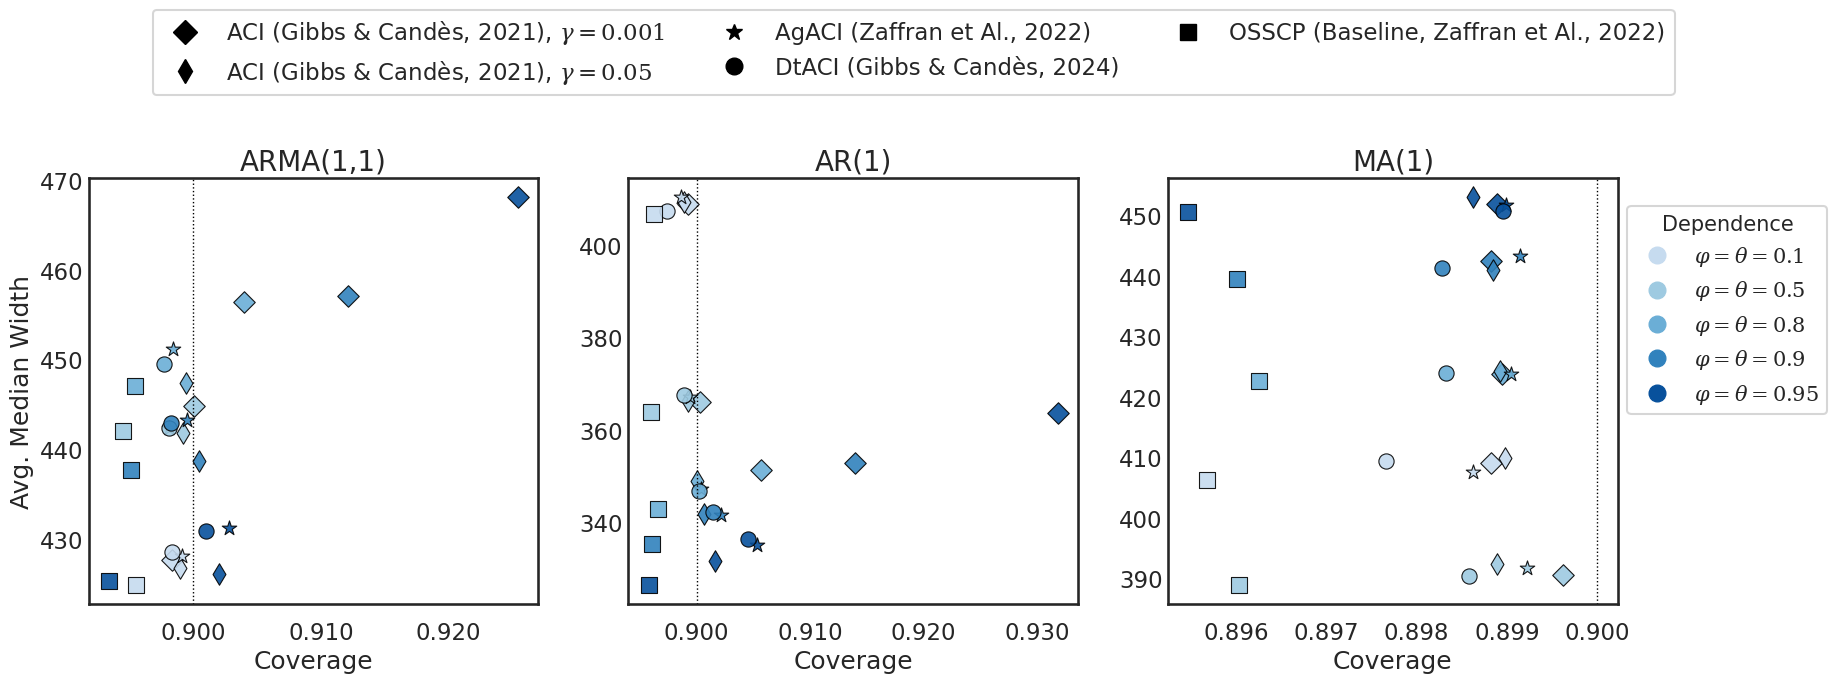


--- Plotting Regime Switching Experiments ---
Figure saved as regime_change_sim.pdf


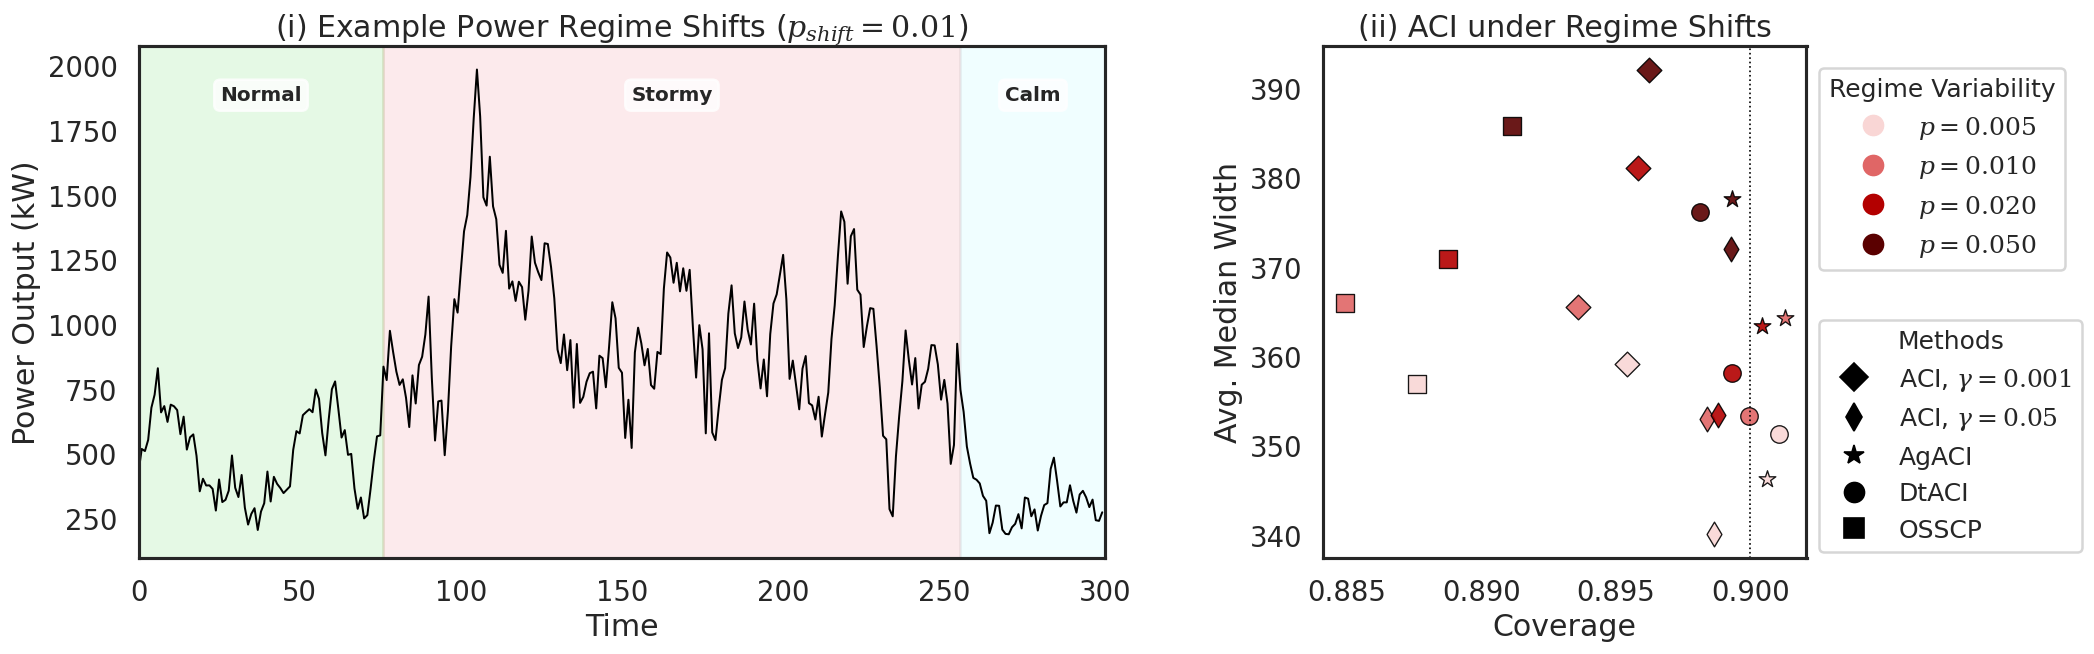


--- Plotting Wind Farm Experiments ---
Figure saved as spatial_sim.pdf


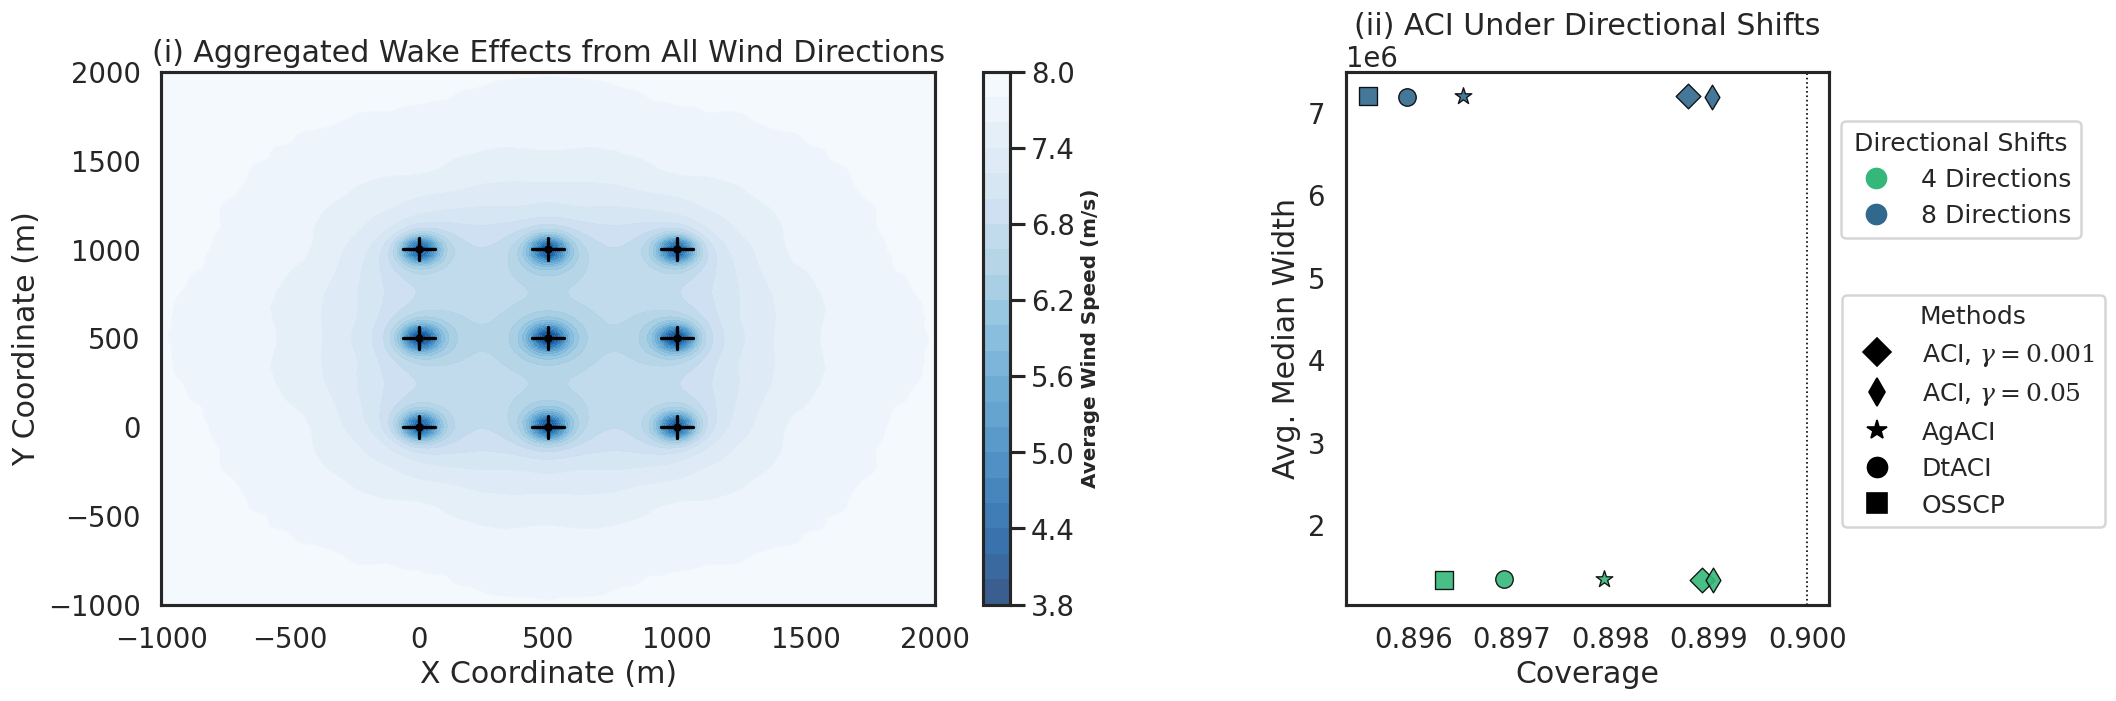


--- All plots generated successfully. ---


In [61]:
plot_all_experiments(ts_results = results["autocorrelation"],
                     regime_results = results["regime_switching"],
                     wind_farm_results = results["wind_farm"],
                     floris_config_path="my_floris_config.yaml")

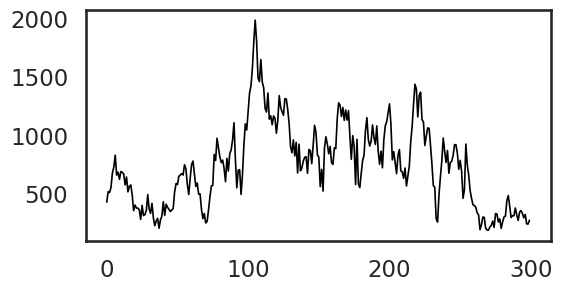

In [47]:
np.random.seed(13) 
power_data, regimes = DataGenerator.regime_switching_process(300, regime_change_prob=0.01)
plt.figure(figsize=(6, 3))
plt.plot(power_data, color='black', linewidth=1.2)

### Plot example 

In [7]:
class ACIExperimentModified(ACIExperiment):
    """Modified for tracking prediction intervals, with external y and preds."""
    
    def run_single_experiment(self, y: np.ndarray, preds: np.ndarray, method: str, 
                              alpha: float, gamma: float, gammas: np.ndarray, I: int, **kwargs) -> tuple:
        T = len(y)
        warmup = int(T * self.config.WARMUP_RATIO)
        residuals = np.abs(y[:warmup] - preds[:warmup]).tolist()
        
        alpha_t = alpha
        betas, covers, lengths = [], [], []
        lowers, uppers = [], []
        
        for t in range(warmup, T):
            alpha_t = np.clip(alpha_t, 1e-10, 1.0 - 1e-10)
            q = np.quantile(residuals, 1 - alpha_t)
            
            lower, upper = preds[t] - q, preds[t] + q
            covered = lower <= y[t] <= upper
            covers.append(covered)
            lengths.append(upper - lower)
            lowers.append(lower)
            uppers.append(upper)
            
            res_t = abs(y[t] - preds[t])
            residuals.append(res_t)
            
            if method == 'aci':
                beta = int(covered)
                out = aci(np.array(betas + [beta]), alpha, gamma, **kwargs)
            elif method == 'agaci':
                beta = np.mean(np.array(residuals) > res_t)
                out = agaci(np.array(betas + [beta]), alpha, gammas, **kwargs)
            elif method == 'dtaci':
                beta = np.mean(np.array(residuals) > res_t)
                I_curr = min(I, len(betas) + 1)
                out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **kwargs)
            else:
                raise ValueError(f"Unknown method: {method}")
            
            betas.append(beta)
            alpha_t = out['alphaSeq'][-1]
        
        return (
            np.mean(covers),
            np.median(lengths),
            np.array(lowers),
            np.array(uppers),
            preds[warmup:]
        )

def plot_aci_comparison(dgp_fn, T=800, alpha=0.1, gamma=0.01, gammas=np.array([0.001, 0.05, 0.1]), I=30, methods=['aci', 'agaci', 'dtaci'], labels=['ACI', 'AgACI', 'DtACI']):
    """Concise plot of true series with overlaid ACI method intervals using shared predictions."""
    experiment = ACIExperimentModified()
    
    np.random.seed(133)  # For reproducibility

    # Generate data and predictions once
    data = dgp_fn(T)
    if isinstance(data, tuple):
        y, _ = data
        preds = UnifiedForecaster.adaptive_forecast(y)
    elif hasattr(data, 'ndim') and data.ndim > 1:
        y = data.sum(axis=1)
        preds = UnifiedForecaster.adaptive_forecast(data).sum(axis=1)
    else:
        y = data
        preds = UnifiedForecaster.adaptive_forecast(y)
    
    warmup = int(T * experiment.config.WARMUP_RATIO)
    t_online = np.arange(warmup, T)
    
    # Run methods on the same y and preds
    results = {}
    for method in methods:
        _, _, lowers, uppers, _ = experiment.run_single_experiment(y, preds, method, alpha, gamma, gammas, I)
        results[method] = {'lowers': lowers, 'uppers': uppers}
    
    # Single plot with overlays (shared predictions)
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(np.arange(T), y, 'k-', label='True Series', lw=2)
    ax.plot(t_online, preds[warmup:], 'm--', label='Shared Predictions', alpha=0.8)  # Shared point estimates
    colors = ['r', 'b', 'g']

    for i, method in enumerate(methods):
        res = results[method]
        ax.fill_between(
            t_online, res['lowers'], res['uppers'],
            color=colors[i], alpha=0.2, label=f'{labels[i]} Interval',
            edgecolor=colors[i], linewidth=1
        )
        ax.plot(t_online, res['lowers'], color=colors[i], linestyle='-')
        ax.plot(t_online, res['uppers'], color=colors[i], linestyle='-')


    
    ax.set_title('ACI Methods Comparison on Simulated Series (Shared Point Estimates)')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Power (kW)')
    ax.grid(True)
    ax.set_xlim(300, T)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

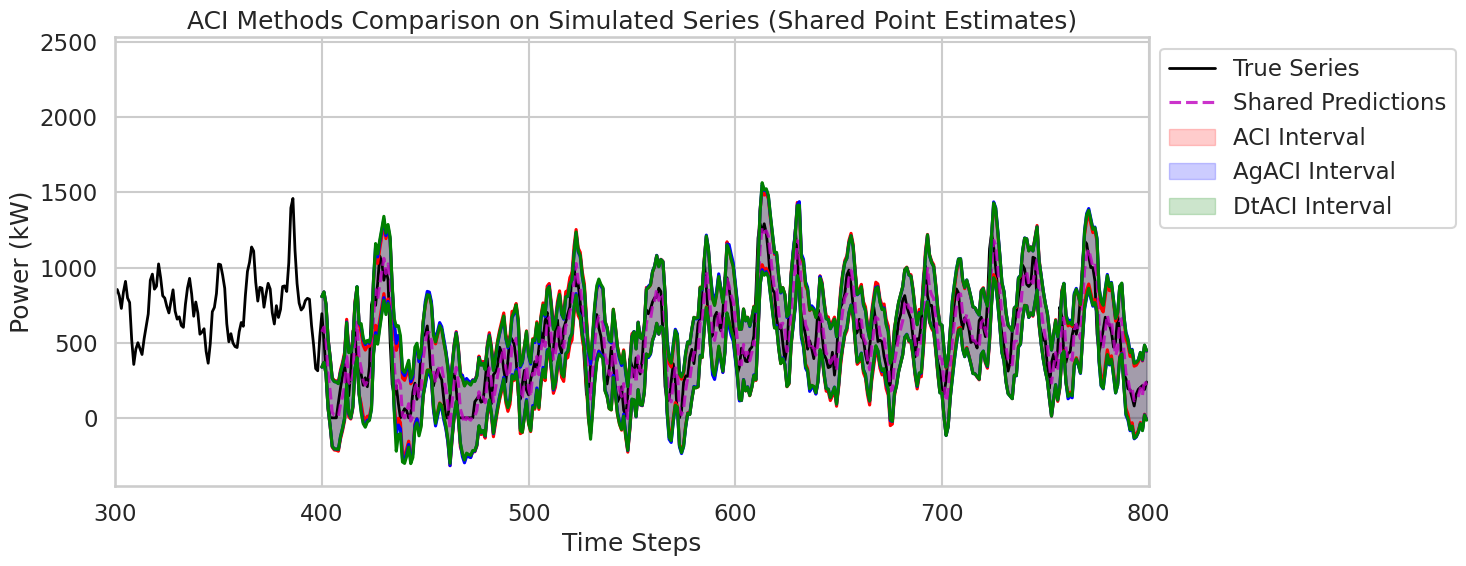

In [8]:
plot_aci_comparison(lambda T: DataGenerator.arma_process(T, phi=0.8, theta = 0.8))

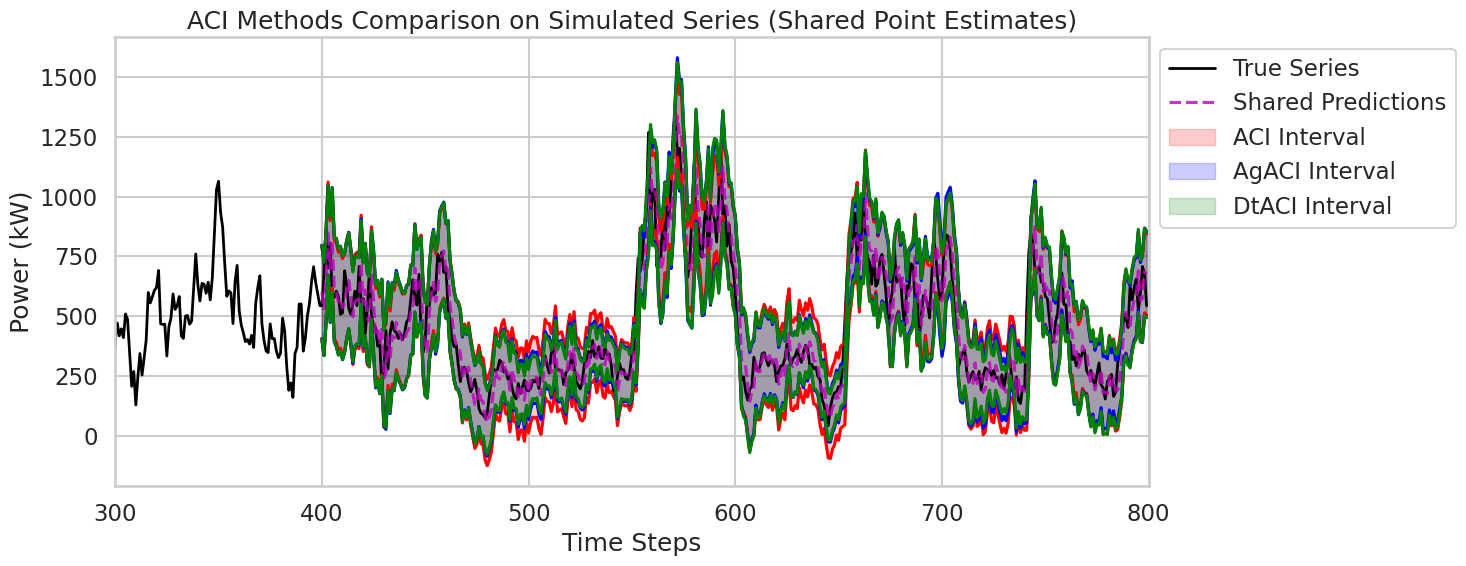

In [9]:
plot_aci_comparison(lambda T: DataGenerator.regime_switching_process(T, regime_change_prob=0.02))

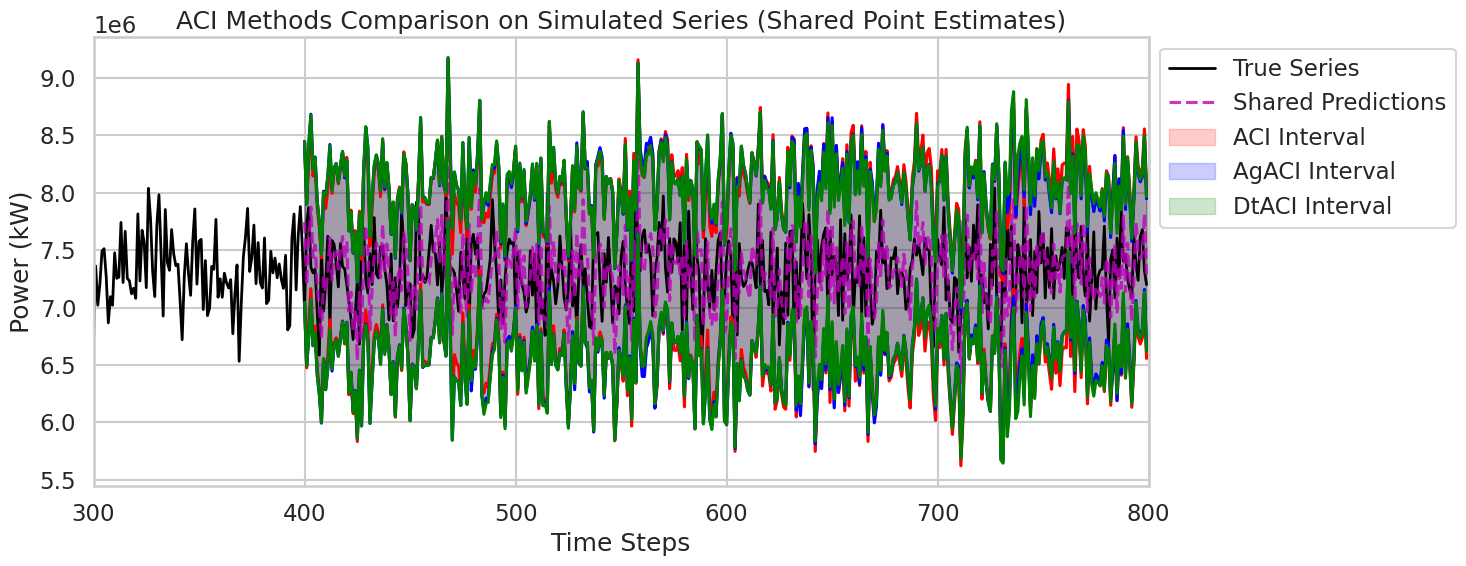

In [11]:
plot_aci_comparison(lambda T: DataGenerator.wind_farm_process(T, floris_config="my_floris_config.yaml"))

### Ablation Non-Conformity

In [27]:
class ACIExperiment:
    """Optimized experiment runner for all ACI methods."""
    
    def __init__(self, config: Optional[Config] = None):
        self.config = config or Config()
        
    def _compute_residuals(self, y: np.ndarray, preds: np.ndarray, 
                          score_type: str, t: int, **kwargs) -> float:
        """Compute residuals efficiently with proper error handling."""
        try:
            if score_type == "pearson":
                # Use adaptive window size
                window_start = max(0, t - min(168, t // 2))
                residuals_window = np.abs(y[window_start:t+1] - preds[window_start:t+1])
                sigma_hat = np.std(residuals_window, ddof=1) if len(residuals_window) > 1 else Config.EPS
                sigma_hat = max(sigma_hat, Config.EPS)
                return np.abs(y[t] - preds[t]) / sigma_hat
            
            elif score_type == "quantile":
                F_val = kwargs.get("F_fn")(np.array([y[t]]), np.array([preds[t]]), **kwargs)
                F_val = np.clip(F_val, Config.EPS, 1 - Config.EPS)
                return np.abs(stats.norm.ppf(F_val))[0]
            
            else:  # absolute residuals
                return np.abs(y[t] - preds[t])
                
        except (ValueError, RuntimeWarning, FloatingPointError):
            # Fallback to absolute residuals on numerical issues
            return np.abs(y[t] - preds[t])
    
    def run_single_experiment(self, r: int, method: str, dgp_fn: Callable, 
                            T: int, alpha: float, gamma: float, 
                            gammas: np.ndarray, I: int, 
                            track_adaptations: bool = False, 
                            score_type: str = "absolute", **kwargs) -> Tuple:
        """Optimized single experiment run with robust error handling."""
        
        # Set seed for reproducibility
        np.random.seed(r * 1000 + hash(method) % 10000)
        
        try:
            # Generate data
            data = dgp_fn(T)
            
            # Handle different data types
            if isinstance(data, tuple):
                y, _ = data
                preds = UnifiedForecaster.adaptive_forecast(y)
            elif hasattr(data, 'ndim') and data.ndim > 1:
                y = data.sum(axis=1)
                preds = UnifiedForecaster.adaptive_forecast(data).sum(axis=1)
            else:
                y = data
                preds = UnifiedForecaster.adaptive_forecast(y)
            
            # Warmup period
            warmup = max(1, min(int(T * self.config.WARMUP_RATIO), T - 10))
            
            # Initialize residuals for warmup period
            residuals = []
            for t in range(warmup):
                res_t = self._compute_residuals(y, preds, score_type, t, **kwargs)
                residuals.append(res_t)
            
            # Online conformal prediction
            alpha_t = alpha
            betas, covers, lengths = [], [], []
            
            # Tracking arrays
            if track_adaptations:
                alpha_hist = []
                cover_hist = []
                res_hist = []
            
            for t in range(warmup, T):
                # Ensure alpha_t is in valid range
                alpha_t = np.clip(alpha_t, Config.ALPHA_MIN, Config.ALPHA_MAX)
                
                # Compute quantile with error handling
                try:
                    q = np.quantile(residuals, 1 - alpha_t)
                except (ValueError, IndexError):
                    q = np.median(residuals) if residuals else 1.0
                
                # Prediction interval
                lower, upper = preds[t] - q, preds[t] + q
                covered = lower <= y[t] <= upper
                
                covers.append(covered)
                lengths.append(max(0, upper - lower))  # Ensure non-negative
                
                # Compute current residual
                res_t = self._compute_residuals(y, preds, score_type, t, **kwargs)
                residuals.append(res_t)
                
                # Update alpha based on method
                try:
                    if method == 'aci':
                        beta = float(covered)
                        out = aci(np.array(betas + [beta]), alpha, gamma, **kwargs)
                    elif method == 'agaci':
                        residual_array = np.array(residuals)
                        beta = np.mean(residual_array > res_t)
                        out = agaci(np.array(betas + [beta]), alpha, gammas, **kwargs)
                    elif method == 'dtaci':
                        residual_array = np.array(residuals)
                        beta = np.mean(residual_array > res_t)
                        I_curr = min(I, len(betas) + 1)
                        out = dtaci(np.array(betas + [beta]), alpha, gammas, I=I_curr, **kwargs)
                    else:
                        raise ValueError(f"Unknown method: {method}")
                    
                    betas.append(beta)
                    alpha_t = np.clip(out['alphaSeq'][-1], Config.ALPHA_MIN, Config.ALPHA_MAX)
                    
                except (ValueError, KeyError, RuntimeWarning, FloatingPointError):
                    # Fallback: keep current alpha
                    betas.append(0.5)  # Neutral beta
                
                if track_adaptations:
                    alpha_hist.append(alpha_t)
                    cover_hist.append(covered)
                    res_hist.append(res_t)
            
            # Return results
            mean_coverage = np.mean(covers) if covers else 0.0
            median_length = np.median(lengths) if lengths else 0.0
            
            return (
                mean_coverage,
                median_length,
                np.array(alpha_hist) if track_adaptations else None,
                np.array(cover_hist) if track_adaptations else None,
                np.array(res_hist) if track_adaptations else None
            )
            
        except Exception as e:
            # Fallback for completely failed experiments
            print(f"Experiment {r} failed with method {method}: {e}")
            return (0.0, 0.0, None, None, None)
    
    def run_parallel_experiment(self, method: str, dgp_fn: Callable, 
                               T: Optional[int] = None, alpha: Optional[float] = None,
                               n_runs: Optional[int] = None, gamma: float = 0.01,
                               gammas: Optional[np.ndarray] = None, I: Optional[int] = None,
                               track_adaptations: bool = False,
                               **model_kwargs) -> Dict[str, Any]:
        """Run parallel experiments with defaults."""
        
        # Use config defaults
        T = T or self.config.DEFAULT_T
        alpha = alpha or self.config.DEFAULT_ALPHA
        n_runs = n_runs or self.config.DEFAULT_RUNS
        I = I or self.config.DEFAULT_I
        gammas = gammas if gammas is not None else self.config.GAMMA_GRID
        
        # Run experiments in parallel
        results = Parallel(n_jobs=-1, verbose=0)(
            delayed(self.run_single_experiment)(
                r, method, dgp_fn, T, alpha, gamma, gammas, I, 
                track_adaptations, **model_kwargs
            ) for r in range(n_runs)
        )
        
        # Process results
        valid_results = [r for r in results if r[0] is not None]
        if not valid_results:
            return {
                'mean_coverage': 0.0, 'std_coverage': 0.0,
                'mean_median_length': 0.0, 'std_median_length': 0.0
            }
        
        covers = np.array([r[0] for r in valid_results])
        lengths = np.array([r[1] for r in valid_results])
        
        output = {
            'mean_coverage': float(np.mean(covers)),
            'std_coverage': float(np.std(covers)),
            'mean_median_length': float(np.mean(lengths)),
            'std_median_length': float(np.std(lengths)),
        }
        
        if track_adaptations:
            tracking_results = [r for r in valid_results if r[2] is not None]
            if tracking_results:
                output.update({
                    'alpha_track': np.array([r[2] for r in tracking_results]),
                    'coverage_track': np.array([r[3] for r in tracking_results]),
                    'residuals_track': np.array([r[4] for r in tracking_results])
                })
        
        return output
    
    def run_method_comparison(self, dgp_fn: Callable, score_type: str = "absolute", 
                             **experiment_kwargs) -> Dict[str, Any]:
        """Run all ACI methods for a specific score type."""
        results = {}
        
        # ACI with different gamma values
        for gamma in self.config.GAMMA_VALUES:
            results[f'ACI_{gamma}'] = self.run_parallel_experiment(
                method='aci', dgp_fn=dgp_fn, gamma=gamma, 
                score_type=score_type, **experiment_kwargs
            )
        
        # AgACI and DtACI
        results['AgACI'] = self.run_parallel_experiment(
            method='agaci', dgp_fn=dgp_fn, score_type=score_type, **experiment_kwargs
        )
        results['DtACI'] = self.run_parallel_experiment(
            method='dtaci', dgp_fn=dgp_fn, score_type=score_type, **experiment_kwargs
        )
        
        return results
    
    def run_score_comparison(self, dgp_fn: Callable, **experiment_kwargs) -> Dict[str, Any]:
        """Run all score types for a given DGP."""
        results = {}
        
        for score_type in self.config.SCORE_TYPES:
            print(f"  Running {score_type} scores...")
            results[score_type] = self.run_method_comparison(
                dgp_fn=dgp_fn, score_type=score_type, **experiment_kwargs
            )
            
        return results


def run_time_series_experiments(params: Optional[List[float]] = None, 
                              processes: Optional[List[str]] = None) -> Dict[str, Any]:
    """Run time series experiments efficiently."""
    experiment = ACIExperiment()
    params = params or [0.1, 0.5, 0.8, 0.9, 0.95]
    processes = processes or ['AR', 'MA', 'ARMA']
    
    process_map = {
        'AR': (DataGenerator.ar_process, 'phi'),
        'MA': (DataGenerator.ma_process, 'theta'), 
        'ARMA': (DataGenerator.arma_process, 'phi')
    }
    process_key_map = {'AR': 'AR1', 'MA': 'MA1', 'ARMA': 'ARMA11'}

    results = {}
    for process_name in processes:
        dgp_class, param_name = process_map[process_name]
        process_results = {}
        
        for param in tqdm(params, desc=f"{process_name} processes"):
            dgp_fn = partial(dgp_class, **{param_name: param})
            process_results[str(param)] = experiment.run_method_comparison(dgp_fn)

        results[process_key_map[process_name]] = process_results
    
    return results


def run_regime_switching_experiments(regime_probs: Optional[List[float]] = None) -> Dict[str, Any]:
    """Run regime-switching experiments."""
    experiment = ACIExperiment()
    regime_probs = regime_probs or [0.005, 0.01, 0.02, 0.05]
    
    results = {}
    for prob in tqdm(regime_probs, desc="Regime switching"):
        dgp_fn = partial(DataGenerator.regime_switching_process, regime_change_prob=prob)
        results[f'regime_prob_{prob}'] = experiment.run_method_comparison(dgp_fn)
    
    return results


def run_wind_farm_experiments(floris_config: str = "my_floris_config.yaml", 
                             wind_directions_sets: Optional[List[List[float]]] = None) -> Dict[str, Any]:
    """Run wind farm experiments with fallback."""
    experiment = ACIExperiment()
    
    if wind_directions_sets is None:
        wind_directions_sets = [
            [0.0, 90.0, 180.0, 270.0],
            [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0]
        ]
    
    results = {}
    try:
        for directions in wind_directions_sets:
            dgp_fn = partial(DataGenerator.wind_farm_process, 
                           floris_config=floris_config, wind_directions=directions)
            results[f'wind_{len(directions)}_dirs'] = experiment.run_method_comparison(dgp_fn)
    except Exception as e:
        print(f"Wind farm experiments failed: {e}")
        # Return empty results rather than crashing
        return {}
    
    return results


def run_comprehensive_experiments() -> Dict[str, Any]:
    """
    DEPRECATED: Use run_comprehensive_score_experiments() instead.
    This function is kept for backward compatibility.
    """
    print("Warning: Using deprecated function. Consider run_comprehensive_score_experiments()")
    return run_comprehensive_score_experiments()


# Quick execution functions for specific needs
def run_quick_comparison(dgp_type: str = 'AR', param: float = 0.8) -> Dict[str, Any]:
    """Quick comparison across all scores for a single DGP configuration."""
    experiment = ACIExperiment()
    
    if dgp_type == 'AR':
        dgp_fn = partial(DataGenerator.ar_process, phi=param)
    elif dgp_type == 'MA':
        dgp_fn = partial(DataGenerator.ma_process, theta=param)
    elif dgp_type == 'ARMA':
        dgp_fn = partial(DataGenerator.arma_process, phi=param)
    elif dgp_type == 'regime':
        dgp_fn = partial(DataGenerator.regime_switching_process, regime_change_prob=param)
    else:
        raise ValueError(f"Unknown DGP type: {dgp_type}")
    
    print(f"Quick comparison: {dgp_type} with parameter {param}")
    return experiment.run_score_comparison(dgp_fn)


def run_method_ablation(score_type: str = 'absolute') -> Dict[str, Any]:
    """Run ablation study focusing on method comparison for a single score type."""
    experiment = ACIExperiment()
    
    # Test on a representative set of DGPs
    dgps = [
        ('AR_low', partial(DataGenerator.ar_process, phi=0.3)),
        ('AR_high', partial(DataGenerator.ar_process, phi=0.9)),
        ('regime_rare', partial(DataGenerator.regime_switching_process, regime_change_prob=0.01)),
        ('regime_frequent', partial(DataGenerator.regime_switching_process, regime_change_prob=0.05))
    ]
    
    results = {}
    for dgp_name, dgp_fn in tqdm(dgps, desc=f"Method ablation ({score_type})"):
        if score_type == 'quantile':
            # Use Gaussian CDF for quantile scores
            score_functions = define_quantile_score_functions()
            results[dgp_name] = experiment.run_method_comparison(
                dgp_fn, score_type=score_type, F_fn=score_functions['gaussian']
            )
        else:
            results[dgp_name] = experiment.run_method_comparison(
                dgp_fn, score_type=score_type
            )
    
    return results

In [28]:
run_method_ablation("quantile")

Method ablation (absolute):   0%|          | 0/4 [00:00<?, ?it/s]

{'AR_low': {'ACI_0.001': {'mean_coverage': 0.89,
   'std_coverage': 0.009082951062292495,
   'mean_median_length': 379.39327019142945,
   'std_median_length': 14.59626871499684},
  'ACI_0.05': {'mean_coverage': 0.8985,
   'std_coverage': 0.0020000000000000074,
   'mean_median_length': 382.4054826381981,
   'std_median_length': 5.935961769555724},
  'AgACI': {'mean_coverage': 0.8979999999999999,
   'std_coverage': 0.004847679857416359,
   'mean_median_length': 373.8547478635736,
   'std_median_length': 17.794683474019816},
  'DtACI': {'mean_coverage': 0.9019999999999999,
   'std_coverage': 0.004000000000000012,
   'mean_median_length': 392.4699406073223,
   'std_median_length': 14.90388725438852}},
 'AR_high': {'ACI_0.001': {'mean_coverage': 0.9215,
   'std_coverage': 0.011467344941179703,
   'mean_median_length': 387.5107881927431,
   'std_median_length': 10.91175840443687},
  'ACI_0.05': {'mean_coverage': 0.9004999999999999,
   'std_coverage': 0.002449489742783194,
   'mean_median_len